In [1]:
import torch
import torch.nn as nn
from pymagnitude import Magnitude
import numpy as np
from tqdm import tqdm_notebook as tqdm
from scipy import spatial
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from pytorch_pretrained_bert import BertTokenizer, BertModel, BertForMaskedLM

%config InlineBackend.figure_format = 'svg'
%matplotlib inline

Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex.


# 1. Embeddings

An embedding maps discrete, categorical values to a continous space. Major advances in NLP applications have come from these continuous representations of words.

If we have some sentence,

In [2]:
sentence = 'the quick brown fox jumps over the lazy dog'
words = sentence.split()
words

['the', 'quick', 'brown', 'fox', 'jumps', 'over', 'the', 'lazy', 'dog']

We first turn this sentence into numbers by assigning each unique word an integer.

In [3]:
word2idx = {word: idx for idx, word in enumerate(sorted(set(words)))}
word2idx

{'brown': 0,
 'dog': 1,
 'fox': 2,
 'jumps': 3,
 'lazy': 4,
 'over': 5,
 'quick': 6,
 'the': 7}

Then, we turn each word in our sentence into its assigned index.

In [4]:
idxs = torch.LongTensor([word2idx[word] for word in sentence.split()])
idxs

tensor([7, 6, 0, 2, 3, 5, 7, 4, 1])

Next, we want to create an **embedding layer**. The embedding layer is a 2-D matrix of shape `(n_vocab x embedding_dimension)`. If we apply our input list of indices to the embedding layer, each value in the input list of indices maps to that specific row of the embedding layer matrix. The output shape after applying the input list of indices to the embedding layer is another 2-D matrix of shape `(n_words x embedding_dimension)`.

In [5]:
embedding_layer = nn.Embedding(num_embeddings=len(word2idx), embedding_dim=3)
embeddings = embedding_layer(idxs)
embeddings, embeddings.shape

(tensor([[ 1.1388, -0.9647, -0.5646],
         [ 0.3627, -1.4765,  0.8175],
         [ 1.2897,  0.4972,  2.0489],
         [-0.3584,  0.2966,  1.1590],
         [ 0.8802,  0.0057,  1.7189],
         [-1.5798,  1.7730,  0.6873],
         [ 1.1388, -0.9647, -0.5646],
         [-0.2072, -0.2173,  1.3478],
         [-0.2548,  2.2945,  0.8094]], grad_fn=<EmbeddingBackward>),
 torch.Size([9, 3]))

The PyTorch builtin embedding layer comes with randomly initialized weights that are updated with gradient descent as your model learns to map input indices to some kind of output. However, often it is better to use pretrained embeddings that do not update but instead are frozen.

## GloVe Embeddings

GloVe embeddings are one of the most popular pretrained word embeddings in use. You can download them [here](https://nlp.stanford.edu/projects/glove/). For the best performance for most applications, I recommend using their Common Crawl embeddings with 840B tokens; however, they take the longest to download, so instead let's download the Wikipedia embeddings with 6B tokens

In [47]:
# Download GloVe vectors
!wget http://nlp.stanford.edu/data/glove.6B.zip && unzip glove.6B.zip && mkdir glove && mv glove*.txt glove

--2019-03-03 14:02:09--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2019-03-03 14:02:09--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  2.57MB/s    in 9m 16s  

2019-03-03 14:11:26 (1.48 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [10]:
GLOVE_FILENAME = 'glove/glove.6B.50d.txt'
glove_index = {}
n_lines = sum(1 for line in open(GLOVE_FILENAME))
with open(GLOVE_FILENAME) as fp:
    for line in tqdm(fp, total=n_lines):
        split = line.split()
        word = split[0]
        vector = np.array(split[1:]).astype(float)
        glove_index[word] = vector

Because the length of the input sequence is 9 words and the embedding dimension is 50, the output shape is `(9 x 50)`.

In [84]:
glove_embeddings = np.array([glove_index[word] for word in words])
glove_embeddings.shape

(9, 50)

### Magnitude Library for Fast Vector Loading

Loading the entire GloVe file can take up a lot of memory. We can use the `magnitude` library for more efficient embedding vector loading. You can download the magnitude version of GloVe embeddings [here](https://github.com/plasticityai/magnitude#pre-converted-magnitude-formats-of-popular-embeddings-models).

In [6]:
# !wget http://magnitude.plasticity.ai/glove/light/glove.6B.50d.magnitude glove/

--2019-03-03 18:32:01--  http://magnitude.plasticity.ai/glove/light/glove.6B.50d.magnitude
Resolving magnitude.plasticity.ai (magnitude.plasticity.ai)... 52.216.86.186
Connecting to magnitude.plasticity.ai (magnitude.plasticity.ai)|52.216.86.186|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 102670336 (98M) [binary/octet-stream]
Saving to: ‘glove.6B.50d.magnitude.1’

glove.6B.50d.magnit   3%[                    ]   3.01M  1.93MB/s               ^C


In [14]:
# Load Magnitude GloVe vectors
glove_vectors = Magnitude('glove/glove.6B.50d.magnitude')

In [15]:
glove_embeddings = glove_vectors.query(words)

## Similarity operations on embeddings

In [16]:
cosine_similarity = lambda vector1, vector2: 1 - spatial.distance.cosine(vector1, vector2)

def similarity(word1, word2):
    vector1, vector2 = glove_vectors.query(word1), glove_vectors.query(word2)
    return cosine_similarity(vector1, vector2)

In [17]:
word_pairs = [
    ('dog', 'cat'),
    ('tree', 'cat'),
    ('tree', 'leaf'),
    ('king', 'queen'),
]

for word1, word2 in word_pairs:
    print(f'Similarity between "{word1}" and "{word2}":\t{similarity(word1, word2):.2f}')

Similarity between "dog" and "cat":	0.92
Similarity between "tree" and "cat":	0.57
Similarity between "tree" and "leaf":	0.74
Similarity between "king" and "queen":	0.78


## Visualizing Embeddings

We can demonstrate that embeddings carry semantic information by plotting them. However, because our embeddings are more than three dimensions, they are impossible to visualize. Therefore, we can use an algorithm called t-SNE to project the word embeddings to a lower dimension in order to plot them in 2-D.

In [18]:
ANIMALS = [
    'whale',
    'fish',
    'horse',
    'rabbit',
    'sheep',
    'lion',
    'dog',
    'cat',
    'tiger',
    'hamster',
    'pig',
    'goat',
    'lizard',
    'elephant',
    'giraffe',
    'hippo',
    'zebra',
]

HOUSEHOLD_OBJECTS = [
    'stapler',
    'screw',
    'nail',
    'tv',
    'dresser',
    'keyboard',
    'hairdryer',
    'couch',
    'sofa',
    'lamp',
    'chair',
    'desk',
    'pen',
    'pencil',
    'table',
    'sock',
    'floor',
    'wall',
]

In [19]:
tsne_words_embedded = TSNE(n_components=2).fit_transform(glove_vectors.query(ANIMALS + HOUSEHOLD_OBJECTS))
tsne_words_embedded.shape

(35, 2)

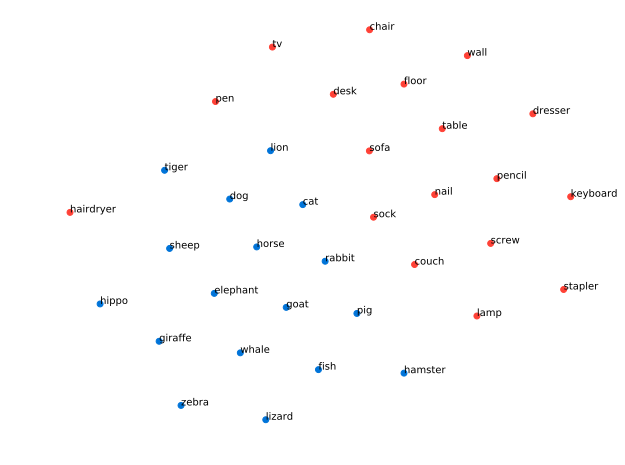

In [20]:
x, y = zip(*tsne_words_embedded)

fig, ax = plt.subplots(figsize=(10, 8))

for i, label in enumerate(ANIMALS + HOUSEHOLD_OBJECTS):
    if label in ANIMALS:
        color = '#0074D9'
    elif label in HOUSEHOLD_OBJECTS:
        color = '#FF4136'
        
    ax.scatter(x[i], y[i], c=color)
    ax.annotate(label, (x[i], y[i]))

ax.axis('off')

plt.show()

## Context embeddings

GloVe and Fasttext are two examples of global embeddings, where the embeddings don't change even though the "sense" of the word might change given the context. This can be a problem for cases such as:

- A **mouse** stole some cheese.
- I bought a new **mouse** the other day for my computer.

The word mouse can mean both an animal and a computer accessory depending on the context, yet for GloVe they would receive the same exact distributed representation. We can combat this by taking into account the surroudning words to create a context-sensitive embedding. Context embeddings such as Bert are really popular right now.



In [3]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [4]:
tokenized_text = tokenizer.tokenize(sentence)
tokenized_text

['the', 'quick', 'brown', 'fox', 'jumps', 'over', 'the', 'lazy', 'dog']

In [5]:
model = BertModel.from_pretrained('bert-base-uncased')
model.eval()

100%|██████████| 407873900/407873900 [23:08<00:00, 293806.66B/s] 


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): BertLayerNorm()
    (dropout): Dropout(p=0.1)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): BertLayerNorm()
            (dropout): Dropout(p=0.1)
          )
        )
        (intermediate): BertIntermediate(
          (dense): Linear(in_features=768, out_features=3072, bias=True)
        )

## Try-it-yourself

- Use the Magnitude library to load other pretrained embeddings such as Fasttext
- Try comparing the GloVe embeddings with the Fasttext embeddings by making t-SNE plots of both, or checking the similarity scores between the same set of words
- Make t-SNE plots using your own words and categories